In [1]:
library(hydra)
library(ape)
library(MASS)
library(stringr)
library(RSpectra)

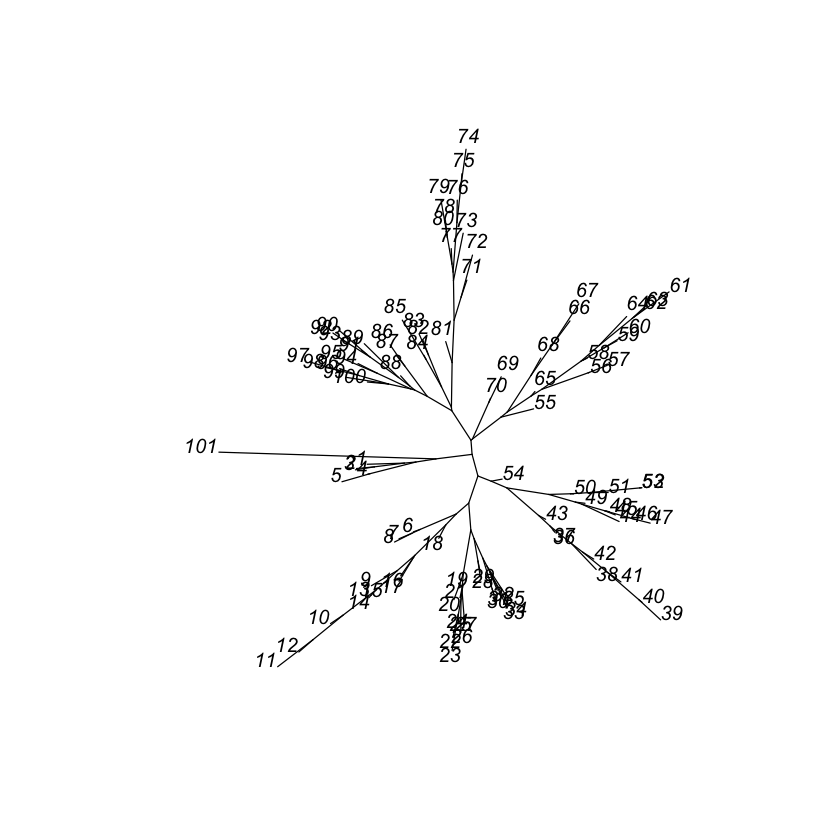

In [23]:
#generate simulation tree

Nleaves <- 100
alpha <- 0.5

tree <- rtree(Nleaves)
tree$tip.label <- 1:Nleaves
for(j in 1:length(tree$edge.length)){
    tree$edge.length[j] <- alpha * (1 - log(runif(1)*(exp(1)-1)+1))
}

tmp <- paste("(",str_sub(write.tree(tree), end=-2),":0.1,",Nleaves+1,":2);",sep="")
tree <- read.tree(text=tmp)

plot(tree, type="unrooted")

In [28]:
#geodesic distance on Poincare ball
Poincare_dist <- function(u,v){
    if(sum(u**2)>=1 || sum(v**2)>=1){
        return(Inf)
    }else{
        return(acosh(1+2*(sum((u-v)**2))/(1-sum(u**2))/(1-sum(v**2))))
    }
}

#embedding dimension
Ms <- c(5,10,20,30)

Nleaves <- length(tree$tip.label)
tree$mrca <- mrca(tree)
D <- dist.nodes(tree)

Nall <- dim(D)[1]
X1 <- D
X2 <- acosh(exp(D))

MSE_H1 <- rep(0, length(Ms))
MSE_H2 <- rep(0, length(Ms))
MSE_MDS <- rep(0, length(Ms))

angle_H1 <- matrix(0, Nleaves*(Nleaves-1)/2, length(Ms))
angle_H2 <- matrix(0, Nleaves*(Nleaves-1)/2, length(Ms))
angle_MDS <- matrix(0, Nleaves*(Nleaves-1)/2, length(Ms))

for(M in Ms){
    #general hyperbolic embeddings
    X1.hydra <- hydraPlus(X1, dim=M, curvature=1, alpha=1, equi.adj=0, control=list(return.dist=1, isotropic.adj=FALSE))
    Z1 <- X1.hydra$r * X1.hydra$directional
    X1.hydra$dist <- hydra:::get.distance(X1.hydra$r, X1.hydra$directional, X1.hydra$curvature)
    
    #our hyperbolic embeddings
    X2.hydra <- hydraPlus(X2, dim=M, curvature=1, alpha=1, equi.adj=0, control=list(return.dist=1, isotropic.adj=FALSE))
    Z2 <- X2.hydra$r * X2.hydra$directional
    X2.hydra$dist <- hydra:::get.distance(X2.hydra$r, X2.hydra$directional, X2.hydra$curvature)

    #Euclidean embeddings
    X1.mds <- sammon(X1, k=M)
    X1.mds$dist <- matrix(0, Nall, Nall)
    for(i in 1:Nall){
        for(j in 1:Nall){
            X1.mds$dist[i,j] <- sqrt(sum((X1.mds$points[i,]-X1.mds$points[j,])**2))
        }
    }

    #MSE
    MSE_H1[which(Ms==M)] <- sum((c(D[upper.tri(D)])-c(X1.hydra$dist[upper.tri(D)]))**2) / choose(Nall,2)
    MSE_H2[which(Ms==M)] <- sum((c(D[upper.tri(D)])-c(log(cosh(X2.hydra$dist[upper.tri(D)]))))**2) / choose(Nall,2)
    MSE_MDS[which(Ms==M)] <- sum((c(D[upper.tri(D)])-c(X1.mds$dist[upper.tri(D)]))**2) / choose(Nall,2)
    
    #Angle information
    idx <- 1
    for(i in 1:(Nleaves-1)){
        for(j in (i+1):Nleaves){
            k <- tree$mrca[i,j]
            
            #general hyperbolic embeddings
            a <- Poincare_dist(Z1[i,], Z1[k,])
            b <- Poincare_dist(Z1[j,], Z1[k,])
            c <- Poincare_dist(Z1[i,], Z1[j,])
            angle_H1[idx,which(Ms==M)] <- acos((cosh(a)*cosh(b)-cosh(c))/(sinh(a)*sinh(b)))
            
            #our hyperbolic embeddings
            a <- Poincare_dist(Z2[i,], Z2[k,])
            b <- Poincare_dist(Z2[j,], Z2[k,])
            c <- Poincare_dist(Z2[i,], Z2[j,])
            angle_H2[idx,which(Ms==M)] <- acos((cosh(a)*cosh(b)-cosh(c))/(sinh(a)*sinh(b)))
            
            #Euclidean embeddings
            a <- sqrt(sum((X1.mds$points[i,]-X1.mds$points[k,])**2))
            b <- sqrt(sum((X1.mds$points[j,]-X1.mds$points[k,])**2))
            c <- sqrt(sum((X1.mds$points[i,]-X1.mds$points[j,])**2))
            angle_MDS[idx,which(Ms==M)] <- acos((a**2+b**2-c**2)/(2*a*b))
            idx <- idx + 1
        }
    }
}

iter   10 value 469.924124
iter   20 value 359.854851
iter   30 value 337.300439
iter   40 value 326.905996
iter   50 value 321.835280
iter   60 value 319.830972
iter   70 value 318.984499
iter   80 value 318.574085
iter   90 value 318.380862
iter  100 value 318.223363
iter  110 value 318.079644
iter  120 value 317.845873
iter  130 value 317.715524
iter  140 value 317.677117
iter  150 value 317.659520
iter  160 value 317.644190
iter  170 value 317.622592
iter  180 value 317.598102
iter  190 value 317.579651
iter  200 value 317.561339
iter  210 value 317.548942
iter  220 value 317.542109
iter  230 value 317.537877
iter  240 value 317.535162
iter  250 value 317.533473
iter  260 value 317.532457
iter  270 value 317.531854
iter  280 value 317.531481
iter  290 value 317.531134
iter  300 value 317.530904
iter  310 value 317.530726
iter  320 value 317.530597
iter  330 value 317.530516
iter  340 value 317.530455
iter  350 value 317.530404
iter  360 value 317.530371
final  value 317.530365 
con

In [29]:
#MSE
result <- rbind(MSE_MDS, MSE_H1, MSE_H2)
colnames(result) <- Ms
rownames(result) <- c("MDS","H1", "H2")
result

,5,10,20,30
MDS,0.22843070,0.045991711,0.0248239345,0.0252232623
H1,0.01579753,0.004016482,0.0030248625,0.0029884050
H2,0.02509713,0.003704609,0.0004400514,0.0001204638


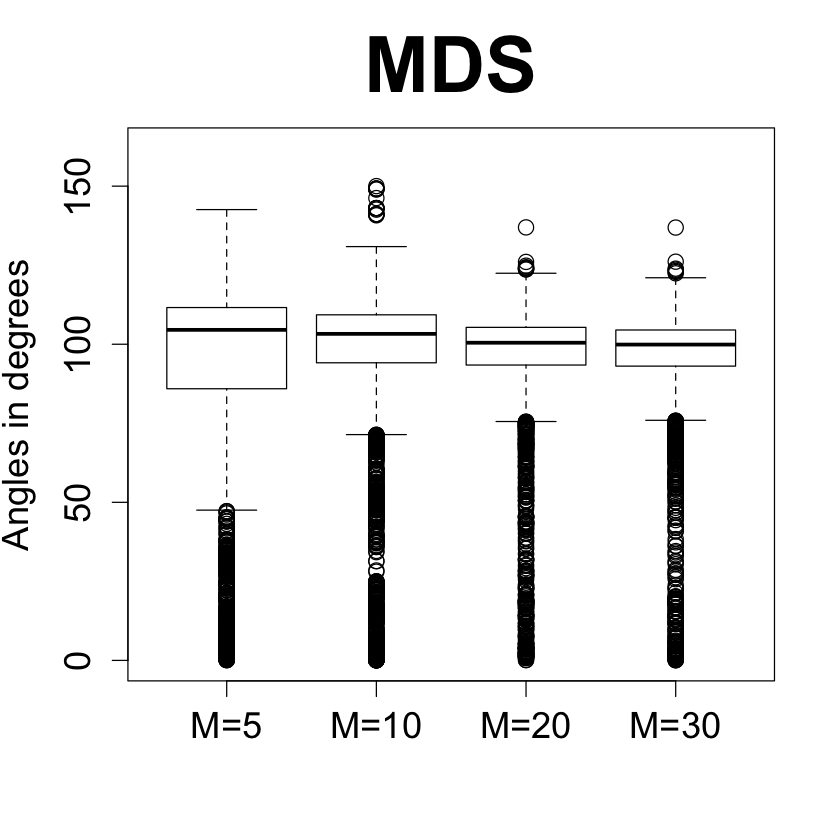

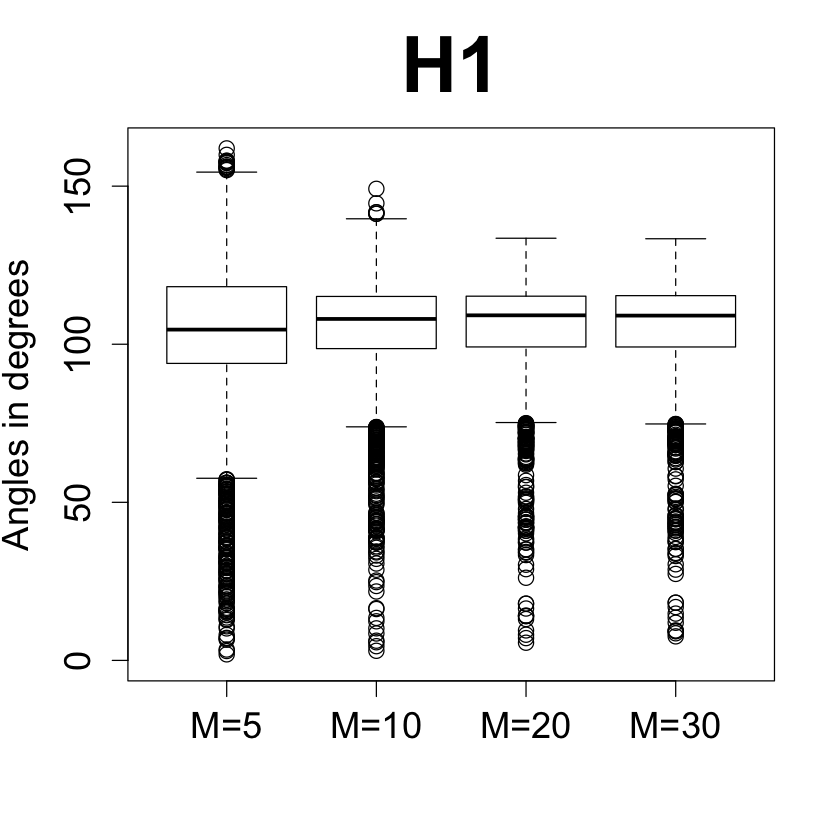

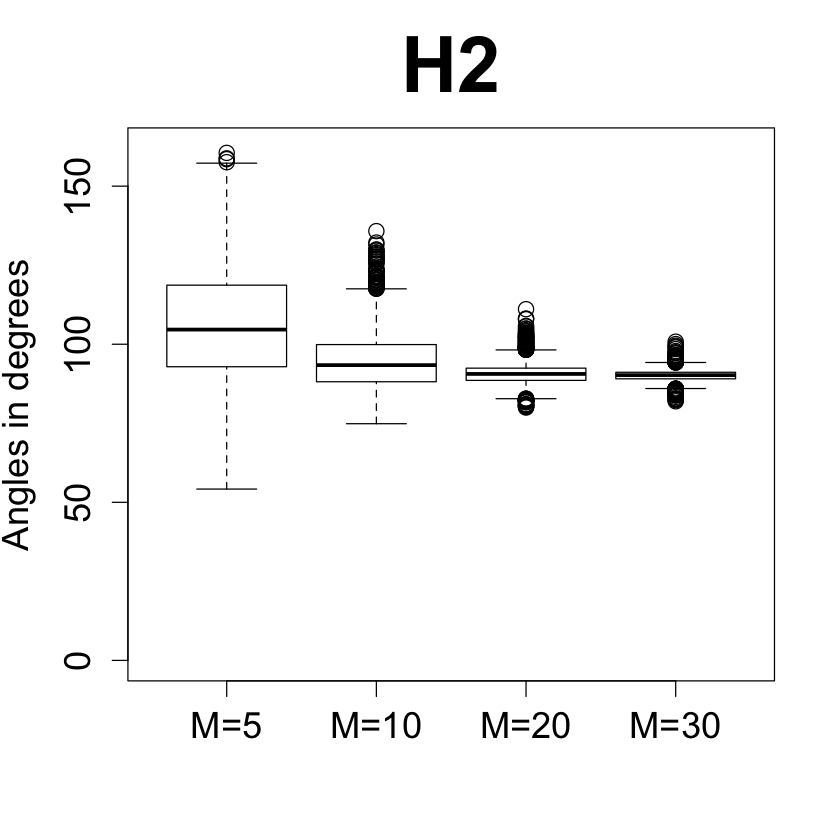

In [30]:
#Angle
yrange <- c(0, max(max(angle_H1/(2*pi)*360),max(angle_H2/(2*pi)*360)))
par(cex=1.3)
tmp <- angle_MDS/(2*pi)*360
tmp2 <- list("M=5"=tmp[,1],"M=10"=tmp[,2],"M=20"=tmp[,3],"M=30"=tmp[,4])
boxplot(tmp2, ylim=yrange, ylab="Angles in degrees", main="MDS", cex.lab=1.4, cex.axis=1.4, cex.main=3)

tmp <- angle_H1/(2*pi)*360
tmp2 <- list("M=5"=tmp[,1],"M=10"=tmp[,2],"M=20"=tmp[,3],"M=30"=tmp[,4])
boxplot(tmp2, ylim=yrange, ylab="Angles in degrees", main="H1", cex.lab=1.4, cex.axis=1.4, cex.main=3)

tmp <- angle_H2/(2*pi)*360
tmp2 <- list("M=5"=tmp[,1],"M=10"=tmp[,2],"M=20"=tmp[,3],"M=30"=tmp[,4])
boxplot(tmp2, ylim=yrange, ylab="Angles in degrees", main="H2", cex.lab=1.4, cex.axis=1.4, cex.main=3)

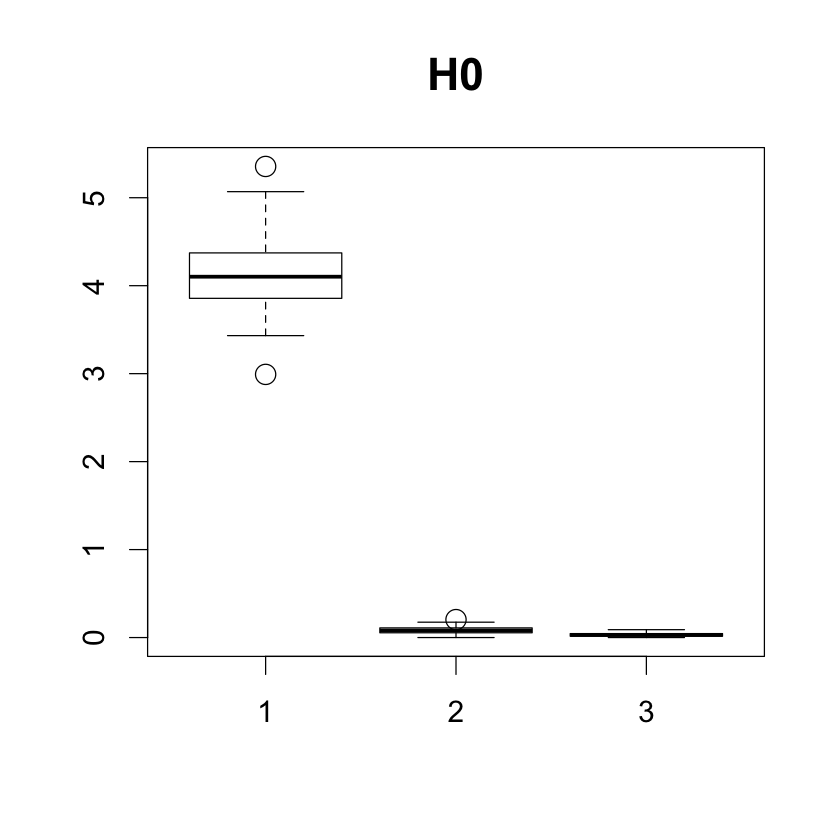

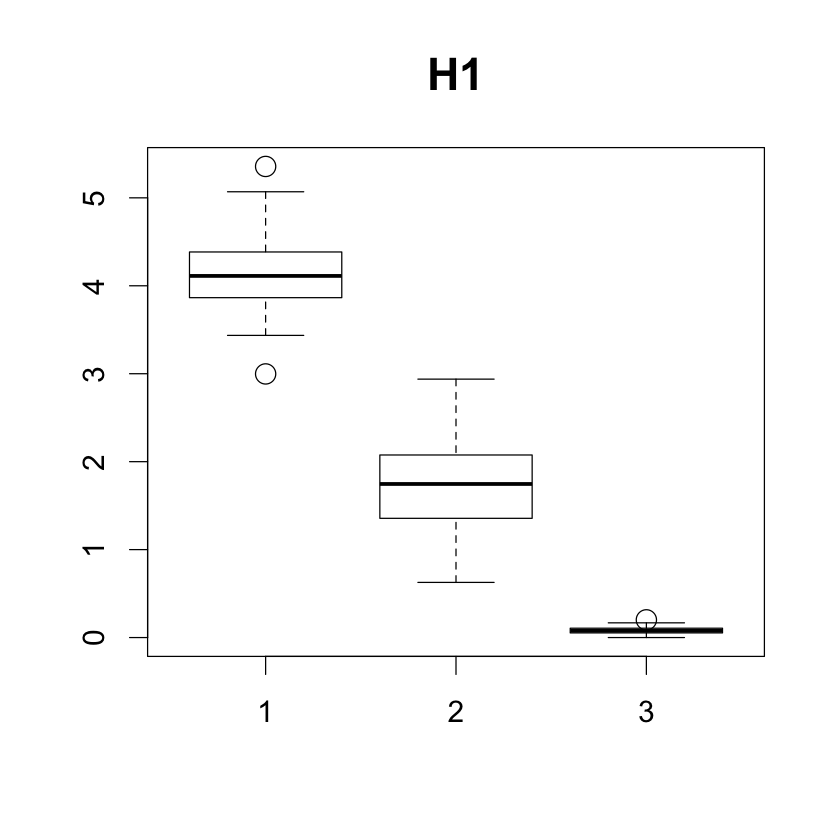

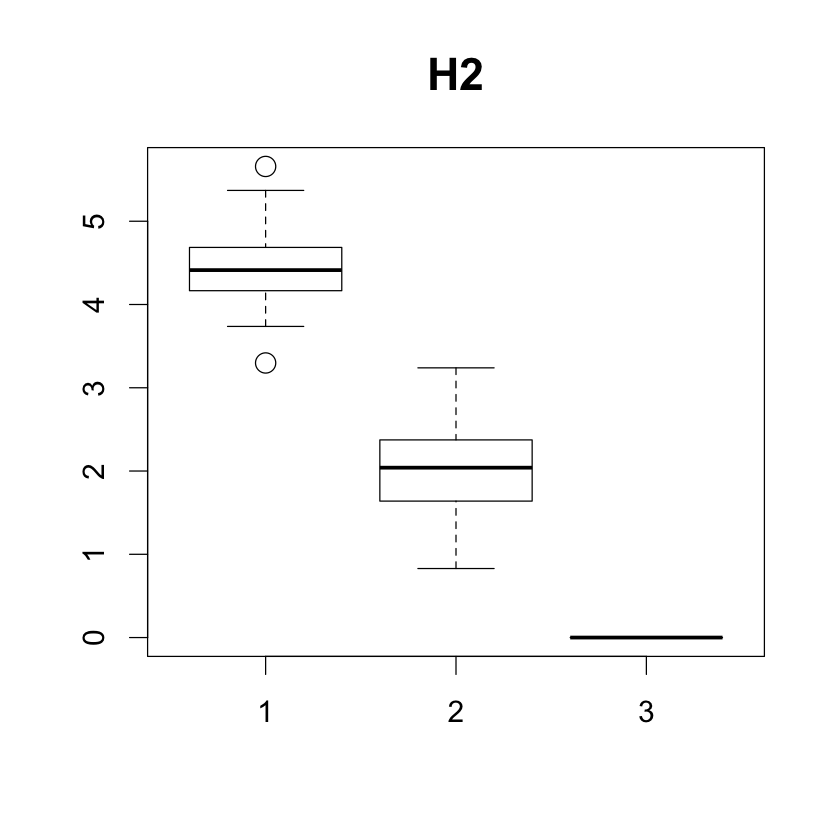

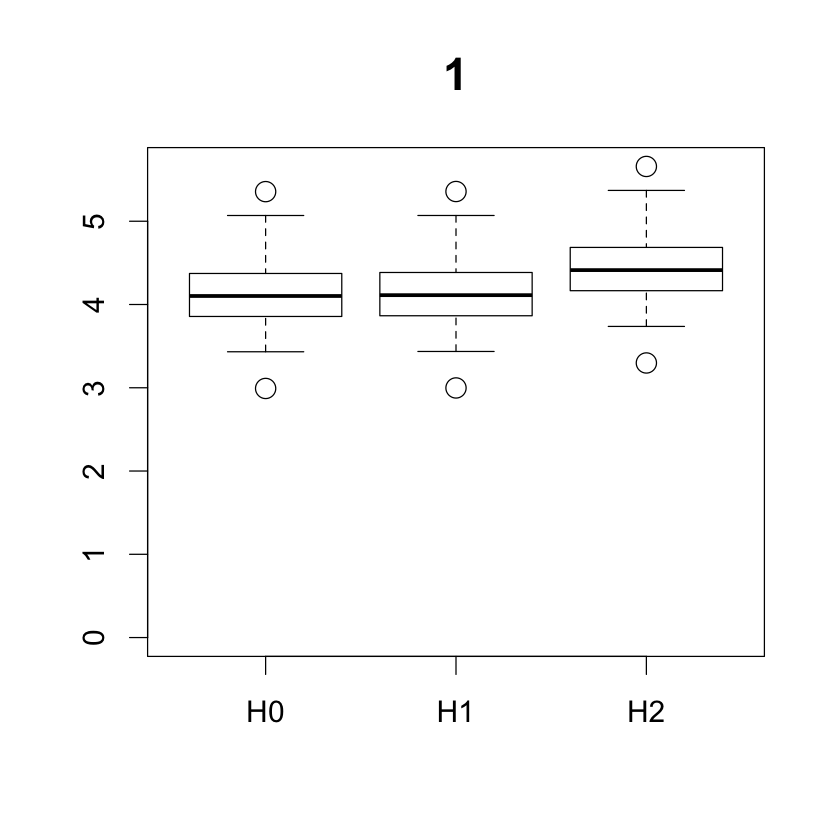

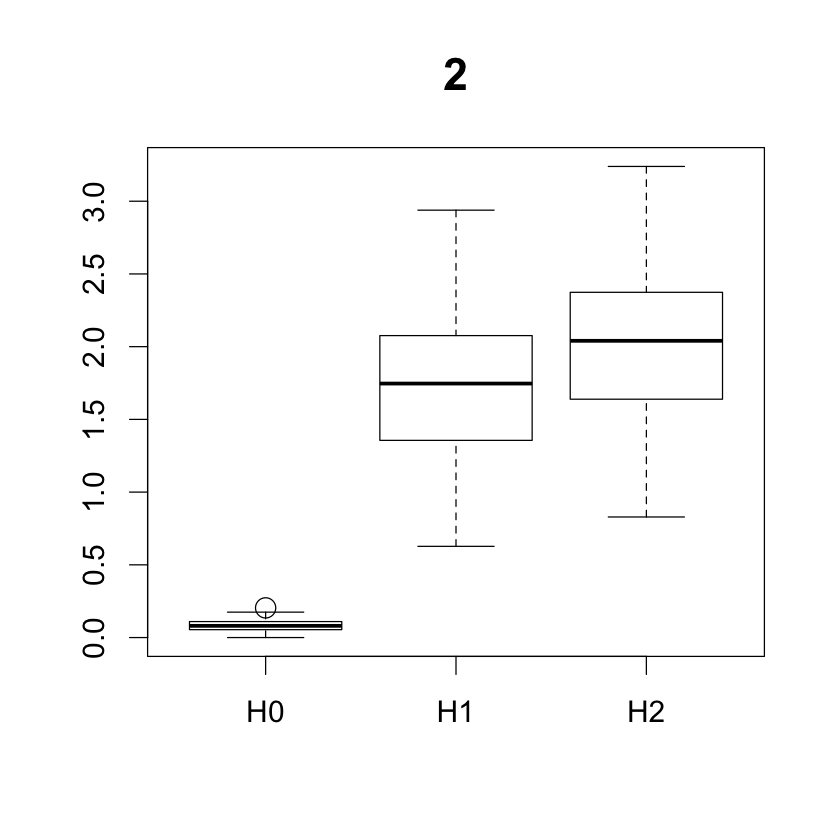

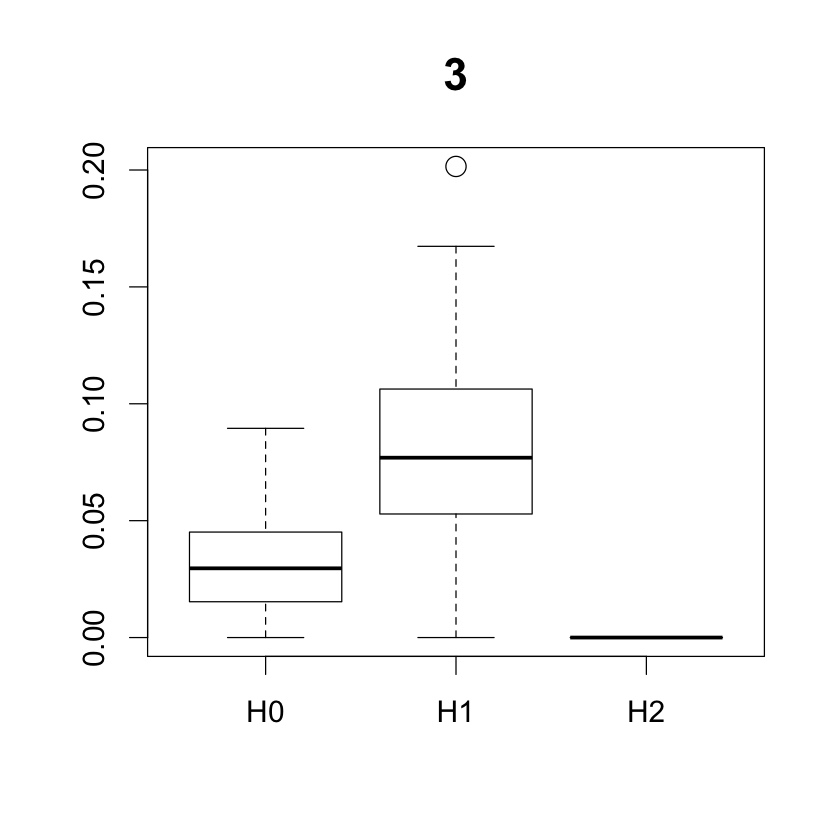

In [7]:
#integrate multiple trees

Nleaves <- 50
alpha <- 0.5

eigen_values_H0 <- matrix(0, 100, 3)
eigen_values_H1 <- matrix(0, 100, 3)
eigen_values_H2 <- matrix(0, 100, 3)

for(ite in 1:100){
    reftree <- rtree(Nleaves)
    reftree$tip.label <- 1:(Nleaves)
    for(i in 1:length(reftree$edge.length)){
        reftree$edge.length[i] <- alpha * (1 - log(runif(1)*(exp(1)-1)+1))
    }
    max_edge_length <- max(reftree$edge.length)
    for(i in 1:length(reftree$edge.length)){
        reftree$edge.length[i] <- reftree$edge.length[i]/max_edge_length
    }
  
    tmp <- sample(1:Nleaves)
    pos1 <- tmp[1]
    pos2 <- tmp[2]
    neg1 <- tmp[3]
    neg2 <- tmp[4]

    reftrees <- c()
    reftree$edge.length[which(reftree$edge[,2]==pos1)] <- 1.0
    reftree$edge.length[which(reftree$edge[,2]==pos2)] <- 1.0
    reftree$edge.length[which(reftree$edge[,2]==neg1)] <- 0.2
    reftree$edge.length[which(reftree$edge[,2]==neg2)] <- 0.2
    reftrees <- c(reftrees, list(reftree))

    reftree$edge.length[which(reftree$edge[,2]==tmp[1])]
    reftree$edge.length[which(reftree$edge[,2]==pos1)] <- 0.2
    reftree$edge.length[which(reftree$edge[,2]==pos2)] <- 0.2
    reftree$edge.length[which(reftree$edge[,2]==neg1)] <- 1.0
    reftree$edge.length[which(reftree$edge[,2]==neg2)] <- 1.0
    reftrees <- c(reftrees, list(reftree))

    #
    D1 <- cophenetic(reftrees[[1]])
    D2 <- cophenetic(reftrees[[2]])
    H0 <- -cosh((D1+D2)/2)
    H1 <- (-cosh(D1)-cosh(D2))/2
    H2 <- (-exp(D1)-exp(D2))/2

    tmp0 <- eigen(H0)
    tmp1 <- eigen(H1)
    tmp2 <- eigen(H2)

    eigen_values_H0[ite,] <- tmp0$values[Nleaves-c(0:2)]
    eigen_values_H1[ite,] <- tmp1$values[Nleaves-c(0:2)]
    eigen_values_H2[ite,] <- tmp2$values[Nleaves-c(0:2)]
}

#
eigen_values_H0[eigen_values_H0>0] <- 0
eigen_values_H1[eigen_values_H1>0] <- 0
eigen_values_H2[eigen_values_H2>0] <- 0

par(cex=1.5)
boxplot(log10(-eigen_values_H0+1), main="H0", cex.main=1.5)
boxplot(log10(-eigen_values_H1+1), main="H1", cex.main=1.5)
boxplot(log10(-eigen_values_H2+1), main="H2", cex.main=1.5)

for(k in 1:3){
  tmp <- cbind(log10(-eigen_values_H0+1)[,k], log10(-eigen_values_H1+1)[,k], log10(-eigen_values_H2+1)[,k])
  boxplot(tmp, names=c("H0", "H1", "H2"), main=k, cex.main=1.5, ylim=c(0, max(tmp)))
}

In [61]:
# imputation from partial trees

L <- 20
Nleaves <- 40
r <- Nleaves + 1
alpha <- 0.5

reftree <- rtree(Nleaves)
reftree$tip.label <- 1:Nleaves
for(i in 1:length(reftree$edge.length)){
    reftree$edge.length[i] <- alpha * (1 - log(runif(1)*(exp(1)-1)+1))
}

tmp <- paste("(",str_sub(write.tree(reftree), end=-2),":0.1,",Nleaves+1,":2);",sep="")
reftree <- read.tree(text=tmp)
Nleaves <- Nleaves+1

#divide leaves
tmp <- sample(1:Nleaves)
idx1 <- sort(tmp[1:(Nleaves/2)])
idx2 <- setdiff(1:Nleaves, idx1)

#common leaves
tmp <- c(sample(1:Nleaves)[1:L], r)
idx1 <- sort(unique(c(tmp, idx1)))
idx2 <- sort(unique(c(tmp, idx2)))

iter   10 value 7.535516
iter   20 value 3.873555
iter   30 value 2.716788
iter   40 value 2.118283
iter   50 value 1.841866
iter   60 value 1.648833
iter   70 value 1.162198
iter   80 value 1.008948
iter   90 value 0.924875
iter  100 value 0.748475
iter  110 value 0.653720
iter  120 value 0.585114
iter  130 value 0.541831
iter  140 value 0.538373
final  value 0.538347 
converged


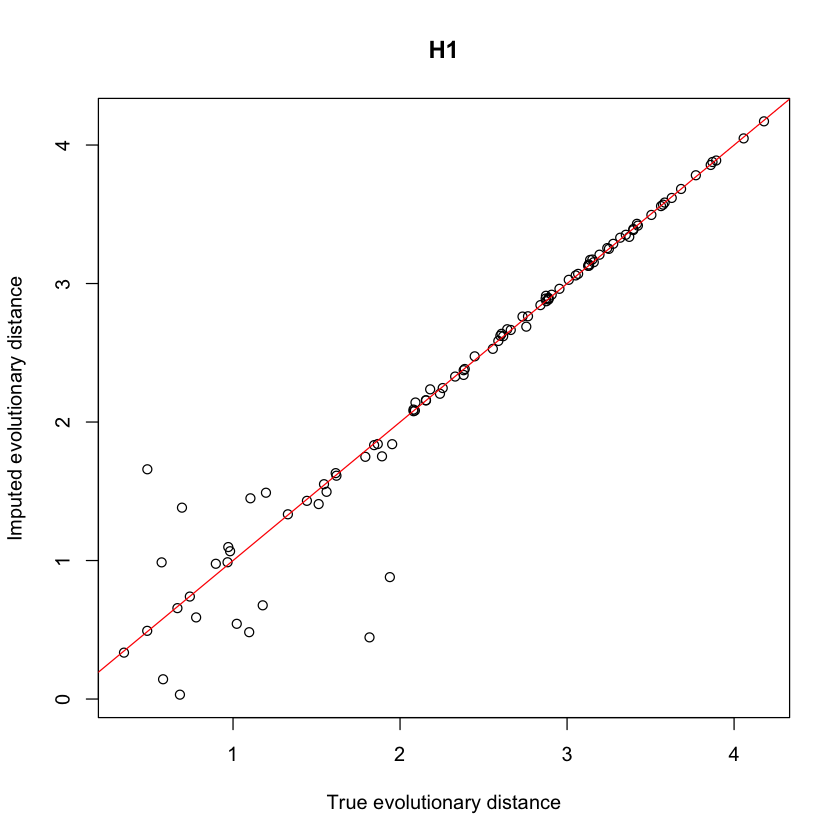

In [62]:
# H1 based imputation

myfn_H1 <- function(para){
    for(i in 1:length(na_pairs)){
        D2[na_pairs[[i]][1], na_pairs[[i]][2]] <- para[i]
        D2[na_pairs[[i]][2], na_pairs[[i]][1]] <- para[i]
    }

    H <- -cosh(D2)

    return(-eigs_sym(H, 2, opts = list(retvec = FALSE), which="SA")$values[1])
}

D <- matrix(NA, Nleaves, Nleaves)
D[idx1, idx1] <- cophenetic(reftree)[idx1, idx1]
D[idx2, idx2] <- cophenetic(reftree)[idx2, idx2]

na_pairs <- list()
for(i in 1:(Nleaves-1)){
    for(j in (i+1):Nleaves){
        if(is.na(D[i,j])){
            na_pairs <- c(na_pairs, list(c(i,j)))
        }
    }
}

D2 <- D
#initialization
tmp <- c()
for(i in 1:length(na_pairs)){
    D2[na_pairs[[i]][1], na_pairs[[i]][2]] <- max(abs(D[na_pairs[[i]][1],]-D[na_pairs[[i]][2],]), na.rm=TRUE)
    D2[na_pairs[[i]][2], na_pairs[[i]][1]] <- D2[na_pairs[[i]][1], na_pairs[[i]][2]]    
    tmp <- c(tmp, D2[na_pairs[[i]][1], na_pairs[[i]][2]])
}

optpara <- optim(tmp, myfn_H1, method="L-BFGS-B", lower=0, upper=2*max(D, na.rm = TRUE), control=list(trace=1, maxit=1000))
for(i in 1:length(na_pairs)){
  D2[na_pairs[[i]][1], na_pairs[[i]][2]] <- optpara$par[i]
  D2[na_pairs[[i]][2], na_pairs[[i]][1]] <- optpara$par[i]
}

a <- setdiff(idx1, idx2)
b <- setdiff(idx2, idx1)
plot(cophenetic(reftree)[a,b], D2[a,b], xlab="True evolutionary distance", ylab="Imputed evolutionary distance", main="H1")
lines(c(-1,10), c(-1,10), col=2)

iter   10 value 12.835557
iter   20 value 6.654405
iter   30 value 4.285604
iter   40 value 3.542717
iter   50 value 2.006628
iter   60 value 1.477704
iter   70 value 1.042648
iter   80 value 0.748575
iter   90 value 0.531171
iter  100 value 0.419709
iter  110 value 0.316280
iter  120 value 0.199995
iter  130 value 0.169475
iter  140 value 0.121368
iter  150 value 0.093516
iter  160 value 0.060313
iter  170 value 0.014036
iter  180 value -0.044759
iter  190 value -0.094327
iter  200 value -0.130514
iter  210 value -0.154770
iter  220 value -0.165997
iter  230 value -0.177650
iter  240 value -0.179766
iter  250 value -0.182945
final  value -0.183713 
converged


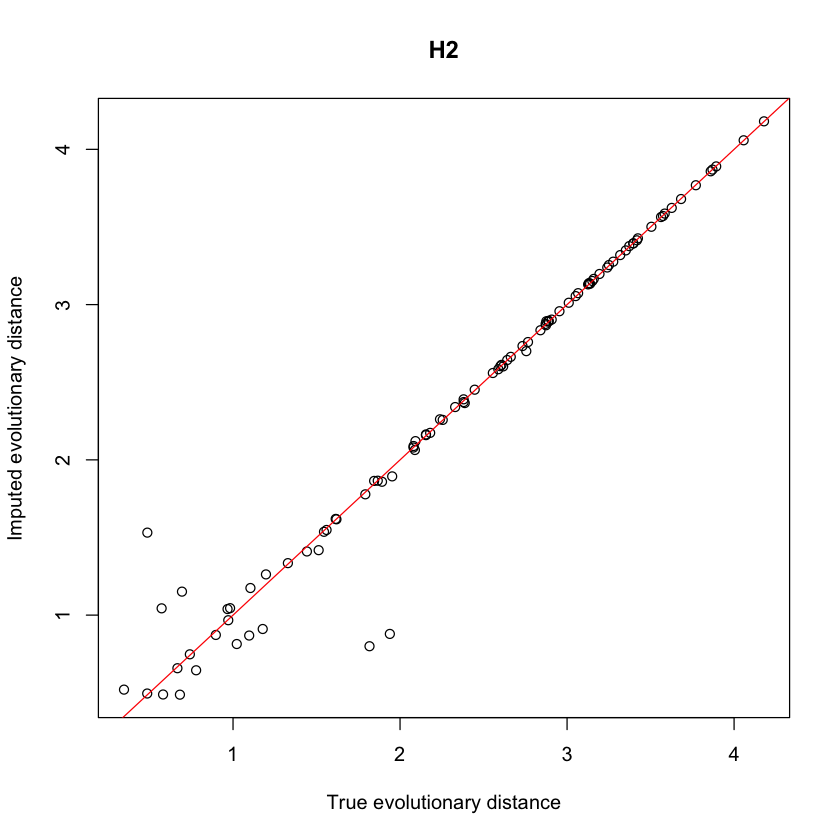

In [63]:
# H2 based imputation

myfn_H2 <- function(para){
    for(i in 1:length(na_pairs)){
        D2[na_pairs[[i]][1], na_pairs[[i]][2]] <- para[i]
        D2[na_pairs[[i]][2], na_pairs[[i]][1]] <- para[i]
    }

    H <- -exp(D2)

    return(-eigs_sym(H, 2, opts = list(retvec = FALSE), which="SA")$values[1])
}

D <- matrix(NA, Nleaves, Nleaves)
D[idx1, idx1] <- cophenetic(reftree)[idx1, idx1]
D[idx2, idx2] <- cophenetic(reftree)[idx2, idx2]

na_pairs <- list()
for(i in 1:(Nleaves-1)){
    for(j in (i+1):Nleaves){
        if(is.na(D[i,j])){
            na_pairs <- c(na_pairs, list(c(i,j)))
        }
    }
}

D2 <- D
#initialization
tmp <- c()
for(i in 1:length(na_pairs)){
    D2[na_pairs[[i]][1], na_pairs[[i]][2]] <- max(abs(D[na_pairs[[i]][1],]-D[na_pairs[[i]][2],]), na.rm=TRUE)
    D2[na_pairs[[i]][2], na_pairs[[i]][1]] <- D2[na_pairs[[i]][1], na_pairs[[i]][2]]
    
    tmp <- c(tmp, D2[na_pairs[[i]][1], na_pairs[[i]][2]])
}

optpara <- optim(tmp, myfn_H2, method="L-BFGS-B", lower=0, upper=2*max(D, na.rm = TRUE), control=list(trace=1, maxit=1000))
for(i in 1:length(na_pairs)){
  D2[na_pairs[[i]][1], na_pairs[[i]][2]] <- optpara$par[i]
  D2[na_pairs[[i]][2], na_pairs[[i]][1]] <- optpara$par[i]
}

a <- setdiff(idx1, idx2)
b <- setdiff(idx2, idx1)
plot(cophenetic(reftree)[a,b], D2[a,b], xlab="True evolutionary distance", ylab="Imputed evolutionary distance", main="H2")
lines(c(-1,10), c(-1,10), col=2)